# Exploring Sea Lions Images

In [1]:
# Pledge: Let's try not to pollute global scope!

import os
import glob
import cv2
import numpy as np
import pandas as pd

from skimage import io, color, feature, draw
from skimage import img_as_float, img_as_ubyte
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_src = "./TrainSmall"
train_imgs = glob.glob(os.path.join(data_src, "Train", "*.jpg"))
dot_imgs = glob.glob(os.path.join(data_src, "TrainDotted", "*.jpg"))

# sort these paths..
train_imgs = sorted(train_imgs)
dot_imgs = sorted(dot_imgs)

In [3]:
def pipeline_find_dots(pth1, pth2):
    # This step in the pipeline is relevant only to pre-processing phase of training
    # We want to identify the locations of annotated dots in img2
    # 
    # pth1 := training image path
    # pth2 := corresponding "dotted" image path
    # out  := output array of dots and class types.
    #
    # Load images
    img1 = img_as_float(io.imread(pth1))
    img2 = img_as_float(io.imread(pth2))
    
    # extract dotted regions
    img = np.abs(img1 - img2)
    m1 = color.rgb2gray(img1)
    m2 = color.rgb2gray(img2)
    img[m1 < 0.07] = 0
    img[m2 < 0.07] = 0
    
    # find blobs
    img_gray = color.rgb2gray(img)
    blobs = feature.blob_log(img_gray, threshold=0.02, min_sigma=3, max_sigma=4)
    
    # classify blobs (these threshold neeed ubyte image)
    def get_sealion_type(im, x, y):
        r, g, b = im[x, y, :]
        sealion = "unknown"
        if r > 200 and b < 50 and g < 50: # red
            sealion = "adult_male"
        elif r > 200 and b > 200 and g < 50: # magenta
            sealion = "sub_adult_male"
        elif r < 100 and b < 100 and 150 < g < 200: # green
            sealion = "pup"
        elif r < 100 and  100 < b and g < 100: # blue
            sealion = "juvenile"
        elif r < 150 and b < 50 and g < 100: # brown
            sealion = "adult_female"
        return sealion
    
    # store blob locations in a dataframe..
    img_name = os.path.split(pth1)[1]
    df = pd.DataFrame(columns=("image_name", "width", "height", "sealion_type"))
    for idx, blb in enumerate(blobs):
        sealion = get_sealion_type(img_as_ubyte(img2), blb[0], blb[1])
        df.loc[idx] = (img_name, blb[0], blb[1], sealion)
    
    # save as csv
    name = img_name.split(".")[0]
    df.to_csv(os.path.join(data_src, name + ".csv"), index_label="id")

In [4]:
# Extract dots of all images. Run parallel loops..
# Parallel(n_jobs=5)(delayed(pipeline_find_dots)(p1, p2) for p1, p2 in zip(train_imgs, dot_imgs))

In [4]:
def pipeline_find_neighbors(pth, max_dist=150):
    # Find the neighbors of all points within the radius 20 pixels.
    # TODO: This function overwrites pth csv file. Is this a bad idea?
    #
    # Runtime complexity: O(N^2) .. 
    #
    # pth := Pth of csv file containing dot (x,y) locations
    def counter(r1):
        neighbors = dict(
            unknown=0,
            adult_male=0,
            sub_adult_male=0,
            pup=0,
            juvenile=0,
            adult_female=0)
        for idx, r2 in df.iterrows():
            dist = (r1.width-r2.width) ** 2 + (r1.height-r2.height) ** 2
            if dist <= max_dist ** 2 and dist > 0:
                neighbors[r2.sealion_type] += 1
        return neighbors

    df = pd.read_csv(pth)
    neighbors = df.apply(counter, axis=1)
    neighbors_cols = ("unknown","adult_male","sub_adult_male","pup","juvenile","adult_female")
    for each in neighbors_cols:
        df["n_" + each] = neighbors.apply(lambda x: x[each])
    df["n_total"] = neighbors.apply(lambda x: sum([x[i] for i in neighbors_cols]))
    
    # update csv file (the same one!)
    df.to_csv(pth)

dot_files = sorted(glob.glob(os.path.join(data_src, "dots-with-bros", "*.csv")))

In [6]:
# Find neighbors. Run parallel loops.
# Parallel(n_jobs=10)(delayed(pipeline_find_neighbors)(p) for p in dot_files)

### Sample neighborhood

In [5]:
# load images. using uint8 will have consequences that we can't immediately see.
# for instance, there could be number overflows that don't really break programs..
img1 = img_as_float(io.imread(train_imgs[0]))
img2 = img_as_float(io.imread(dot_imgs[0]))

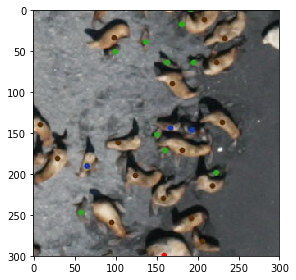

In [6]:
x = 2200; y=3100; d=150
io.imshow(img2[x-d:x+d,y-d:y+d,:])

## Average number of neighbors for each sealion type

For instance, each adult female has
- Approx 10 adult-females, 1 adult male, 2 juveniles, 8 pups in its neighborhood (150px radius)
- Does this trend continue for each image?? Let's find out

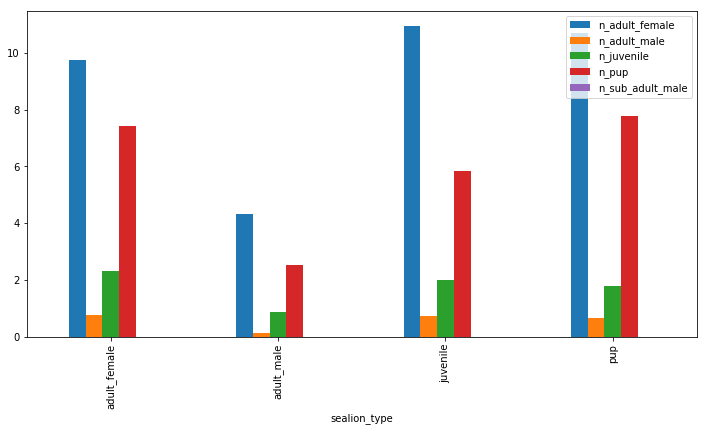

In [7]:
df = pd.read_csv(dot_files[0])
df["count"] = 1
grp = df.groupby("sealion_type")
d = grp.sum() / grp.count()
cols = ["n_adult_female", "n_adult_male", "n_juvenile", "n_pup", "n_sub_adult_male"]
d[cols].plot(kind="bar", figsize=(12,6))

In [8]:
def query_neighbors_of_all_imgs(dot_files):
    # TODO: This plot is not reasonable.
    # number of dots in each image is diff -- the equalizer " sum / count " seems to be
    # not a good indicator.. verify!!
    #
    df_store = dict(
        adult_female = pd.DataFrame(columns=cols),
        adult_male = pd.DataFrame(columns=cols),
        juvenile = pd.DataFrame(columns=cols),
        pup = pd.DataFrame(columns=cols),
        sub_adult_male = pd.DataFrame(columns=cols),
        unknown = pd.DataFrame(columns=cols))

    for idx, p in enumerate(dot_files):
        df = pd.read_csv(p)
        df["count"] = 1
        grp = df.groupby("sealion_type")
        d = grp.sum() / grp.count()

        def add(row):
            df_store[row.name].loc[idx] = row.values
            
        d[cols].apply(add, axis=1)
    
    return df_store

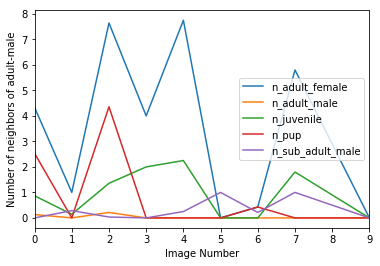

In [9]:
# Clearly, I am disappointed with this graph.. was expecting some correleations!!!
# Let's see on the large dataset!!
df_store = query_neighbors_of_all_imgs(dot_files)
ax = df_store["adult_male"].plot()
ax.set_xlabel("Image Number")
ax.set_ylabel("Number of neighbors of adult-male")

# Contours: Finding the shape of sea lions

In [10]:
img_num = 1
df = pd.read_csv(dot_files[img_num])
print dot_files[img_num]
print train_imgs[img_num]
df.head()

./TrainSmall/dots-with-bros/42.csv
./TrainSmall/Train/42.jpg


,Unnamed: 0,id,image_name,width,height,sealion_type,n_unknown,n_adult_male,n_sub_adult_male,n_pup,n_juvenile,n_adult_female,n_total
0,0,0,42.jpg,317.0,4878.0,adult_male,0,0,0,0,0,0,0
1,1,1,42.jpg,466.0,4274.0,adult_male,0,0,0,0,1,1,2
2,2,2,42.jpg,546.0,4175.0,juvenile,0,1,0,0,0,1,2
3,3,3,42.jpg,570.0,4199.0,adult_female,0,1,0,0,1,0,2
4,4,4,42.jpg,1449.0,3653.0,sub_adult_male,0,0,0,0,0,0,0


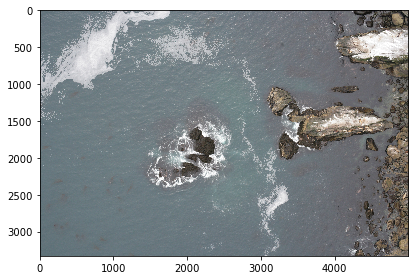

In [11]:
img = img_as_float(io.imread(train_imgs[img_num]))
io.imshow(img)

### Notes

- Except the case of pups, all other sea lions have same color distribution (approx)
- This color seems to be distinct from the background. We need to leverage this -- gray scale looses this information. May be, calculate YCbCr and scrap out the luminance and just work on "color" information? I guess this wouldn't work for pups... they seem to be more blend-into background (verify!!)

/Users/suryak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


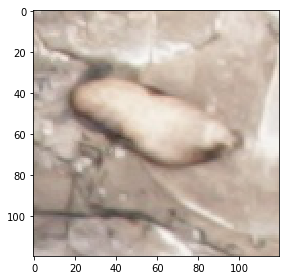

In [109]:
x = df.loc[1].width
y = df.loc[1].height
d = 60
region = img[x-d:x+d,y-d:y+d,:]
io.imshow(region)

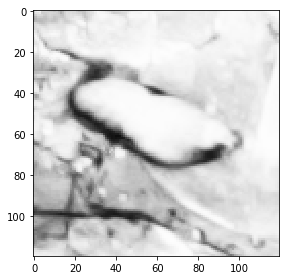

In [110]:
from skimage import exposure, feature, filters, segmentation

region_gray = color.rgb2gray(region) #
region_gray = exposure.adjust_sigmoid(region_gray) # contrast adjustment.
region_gray = filters.gaussian(region_gray, sigma=0.3) # gaussian smooth
io.imshow(region_gray)

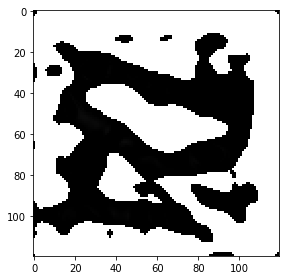

In [111]:
#io.imshow( color.rgb2hsv(region)[:,:,1] )
from skimage import morphology

io.imshow(
    filters.hessian(region_gray, (4,8), beta1=0.05, beta2=1)
)

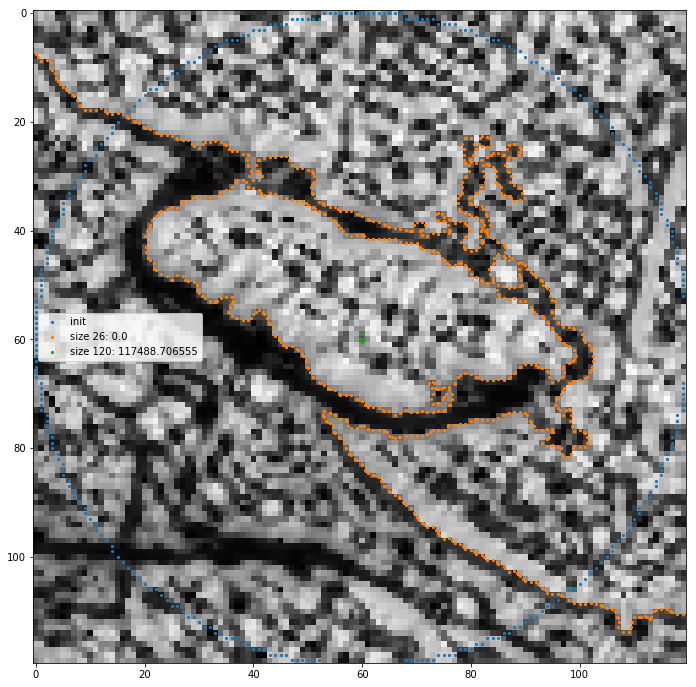

In [292]:
from skimage import measure, exposure, morphology

rr1, cc1 = draw.ellipse_perimeter(d, d, d, d, orientation=3*(np.pi/4), shape=region_gray.shape)
init = np.array([rr1, cc1], dtype=np.float64).T

from skimage.feature import shape_index
region_shape = exposure.rescale_intensity(shape_index(region_gray, sigma=0.1), in_range=(-1,1), out_range=(0,1))


# Gray image: w_line: 0.02, w_edge: 0.25, alpha=0.3, iter: 100
# Hessian: range: 5,8 beta1: 0.03, beta2: 0.5; w_line=0, w_edge=0.2, alpha=0.8, iter=50-100
p = filters.hessian(region_gray, (4,8), beta1=0.05, beta2=1)
contours = measure.find_contours(region_gray * region_shape, 0.4)


fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(region_gray*region_shape, interpolation="nearest", cmap=plt.cm.gray)
ax.scatter(rr1, cc1, s=5, label="init")
total_area = np.prod(draw.polygon(rr1, cc1)[0].shape)
areas = []
for idx, cnt in enumerate(contours):
    cc2, rr2 = cnt.T
    cnt_region = draw.polygon(rr2, cc2)
    if d in cnt_region[0] and d in cnt_region[1]:
        area = np.prod(cnt_region)
        areas.append((area, idx))
        ax.scatter(rr2, cc2, s=5, label="size {0}: {1}".format(idx, (100.0 * area) / total_area))
plt.legend()
plt.show()

In [123]:
areas

[(0, 2), (0, 7)]

In [186]:
cnt1 = contours[2]
cnt2 = contours[7]

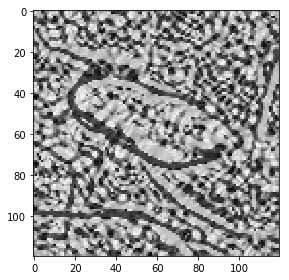

In [282]:
io.imshow(region_shape)